In [1]:
import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
import scipy
from sklearn.model_selection import GroupKFold
from sklearn import linear_model
from lineartree import RandomForestRegressor
from sklearn import metrics
import matplotlib.pyplot as plt

In [2]:
def rae(actual, predicted):
    numerator = np.sum(np.abs(predicted - actual))
    denominator = np.sum(np.abs(np.mean(actual) - actual))
    return numerator / denominator

In [3]:
def peak_eV_nm(peak_eV):
    return 1239.84193/peak_eV

In [4]:
def FWHM_eV_nm(peak_eV,fwhm_eV):
    return  2*(1239.84193/(peak_eV-fwhm_eV/2) - 1239.84193/(peak_eV))

In [5]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), UV Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 7, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 2, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 17, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV): \t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_UV_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_UV_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_UV_Val_cascade.csv", matrix_cascade, delimiter=",")

Absorbance Peak
MAE (eV): 	 0.1005 0.0061
R2 (eV):	 0.6442 0.0456
RAE (eV):	 0.5814 0.0443
RMSE (eV):	 0.1270 0.0075
Importances	 [0.13808 0.1659  0.20082 0.07876 0.41645]
MAE (nm):	 21.5597 1.2550
R2 (nm):	 0.6233 0.0515
RAE (nm):	 0.5902 0.0448
RMSE (nm):	 27.3900 1.5743
Absorbance FWHM (direct)
MAE (eV):	 0.0103 0.0007
R2 (eV):	 0.6745 0.0583
RAE (eV):	 0.4981 0.0330
RMSE (eV):	 0.0148 0.0019
Importances	 [0.12426 0.19661 0.20549 0.155   0.31864]
MAE (nm):	 3.9258 0.2136
R2 (nm):	 0.5026 0.0654
RAE (nm):	 0.6618 0.0516
RMSE (nm):	 5.2061 0.4311
Absorbance FWHM (cascade)
MAE (eV):	 0.0104 0.0007
R2 (eV):	 0.6666 0.0660
RAE (eV):	 0.5048 0.0355
RMSE (eV):	 0.0150 0.0021
Importances	 [0.0965  0.16632 0.16829 0.12508 0.26483 0.17898]
MAE (nm):	 3.9157 0.2256
R2 (nm):	 0.4989 0.0655
RAE (nm):	 0.6598 0.0487
RMSE (nm):	 5.2295 0.4797


In [6]:
#Test Linear Regression on Train/Val set, 10-fold cross validation (Group splits), PL Peak, FWHM (eV), Normalized
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 17, 
                                       min_samples_split = 9, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=17, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

#Split groups for cross validation by Experiment number
gkf = GroupKFold(n_splits=10)
matrix = np.zeros([10,13])
matrix_fwhm = np.zeros([10,13])
matrix_cascade = np.zeros([10,14])

j = 0
#Loop through the 10 splits
for train_index, test_index in gkf.split(X, groups=group):
    #Separate out training and test sets
    X_train = X.iloc[train_index, :]
    X2_train = X2.iloc[train_index, :]
    y_train = y[train_index]
    z_train = z[train_index]
    X_test = X.iloc[test_index, :]
    y_test = y[test_index]
    z_test = z[test_index]

    #prediction for Peak
    regressor_peak.fit(X_train, y_train)
    y_pred = regressor_peak.predict(X_test)
    #prediction for FWHM (direct)
    regressor_fwhm.fit(X_train, z_train)
    y_pred_fwhm = regressor_fwhm.predict(X_test)
    #prediction for FWHM (cascade)
    regressor_cascade.fit(X2_train, z_train)
    X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
    y_pred_cascade = regressor_cascade.predict(X_test)

    #errors in eV (normalized)
    
    #UN-normalize eV predictions by scaling with ratio

    ratio = (1239.84193/400 - 1239.84193/620)
    ratio2 = 0.35
    matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
    matrix[j,1] = metrics.r2_score(y_test, y_pred)
    matrix[j,2] = rae(y_test, y_pred)
    matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

    matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
    matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
    matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
    matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

    matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
    matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
    matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
    matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

    #errors in nm
    #UNnormalize the data first
    y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
    z_test = z_test*(0.35)+0.05
    y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
    y_pred_cascade = y_pred_cascade*(0.35)+0.05
    
    #Calculate data in nm and eV
    matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
    matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
    matrix[j,8:13] = regressor_peak.feature_importances_

    matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
    matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
    matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

    matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
    matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
    matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

    j+=1

matrix_2 = np.zeros([1,21])
matrix_2[0,:8] = matrix.mean(0)[:8]
matrix_2[0,8:16] = np.std(matrix[:,:8], axis=0)
matrix_2[0,16:21] = matrix.mean(0)[8:13]

matrix_3 = np.zeros([1,21])
matrix_3[0,:8] = matrix_fwhm.mean(0)[:8]
matrix_3[0,8:16] = np.std(matrix_fwhm[:,:8], axis=0)
matrix_3[0,16:21] = matrix_fwhm.mean(0)[8:13]

matrix_4 = np.zeros([1,22])
matrix_4[0,:8] = matrix_cascade.mean(0)[:8]
matrix_4[0,8:16] = np.std(matrix_cascade[:,:8], axis=0)
matrix_4[0,16:22] = matrix_cascade.mean(0)[8:14]

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_2[0,0]), "{:.4f}".format(matrix_2[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_2[0,1]), "{:.4f}".format(matrix_2[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_2[0,2]), "{:.4f}".format(matrix_2[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_2[0,3]), "{:.4f}".format(matrix_2[0,11]))
print("Importances\t", matrix_2[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_2[0,4]), "{:.4f}".format(matrix_2[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_2[0,5]), "{:.4f}".format(matrix_2[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_2[0,6]), "{:.4f}".format(matrix_2[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_2[0,7]), "{:.4f}".format(matrix_2[0,15]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_3[0,0]), "{:.4f}".format(matrix_3[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_3[0,1]), "{:.4f}".format(matrix_3[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_3[0,2]), "{:.4f}".format(matrix_3[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_3[0,3]), "{:.4f}".format(matrix_3[0,11]))
print("Importances\t", matrix_3[0,16:21])
print("MAE (nm):\t","{:.4f}".format(matrix_3[0,4]), "{:.4f}".format(matrix_3[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_3[0,5]),"{:.4f}".format(matrix_3[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_3[0,6]), "{:.4f}".format(matrix_3[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_3[0,7]), "{:.4f}".format(matrix_3[0,15]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_4[0,0]), "{:.4f}".format(matrix_4[0,8]))
print("R2 (eV):\t", "{:.4f}".format(matrix_4[0,1]), "{:.4f}".format(matrix_4[0,9]))
print("RAE (eV):\t", "{:.4f}".format(matrix_4[0,2]), "{:.4f}".format(matrix_4[0,10]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_4[0,3]), "{:.4f}".format(matrix_4[0,11]))
print("Importances\t", matrix_4[0,16:22])
print("MAE (nm):\t","{:.4f}".format(matrix_4[0,4]), "{:.4f}".format(matrix_4[0,12]))
print("R2 (nm):\t", "{:.4f}".format(matrix_4[0,5]),"{:.4f}".format(matrix_4[0,13]))
print("RAE (nm):\t","{:.4f}".format(matrix_4[0,6]), "{:.4f}".format(matrix_4[0,14]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_4[0,7]), "{:.4f}".format(matrix_4[0,15]))

np.savetxt("RF_PL_Val_peak.csv", matrix, delimiter=",")
np.savetxt("RF_PL_Val_fwhm.csv", matrix_fwhm, delimiter=",")
np.savetxt("RF_PL_Val_cascade.csv", matrix_cascade, delimiter=",")

Emission Peak
MAE (eV):	 0.0968 0.0025
R2 (eV):	 0.5860 0.0341
RAE (eV):	 0.6298 0.0321
RMSE (eV):	 0.1224 0.0031
Importances	 [0.1274  0.17679 0.24913 0.08378 0.3629 ]
MAE (nm):	 22.1405 0.7084
R2 (nm):	 0.5728 0.0385
RAE (nm):	 0.6353 0.0341
RMSE (nm):	 28.0252 0.9042
Emission FWHM (direct)
MAE (eV):	 0.0098 0.0007
R2 (eV):	 0.6013 0.0794
RAE (eV):	 0.5831 0.0478
RMSE (eV):	 0.0137 0.0013
Importances	 [0.14806 0.18061 0.1614  0.15136 0.35857]
MAE (nm):	 3.7390 0.1469
R2 (nm):	 0.4849 0.0699
RAE (nm):	 0.6954 0.0441
RMSE (nm):	 4.9172 0.1716
Emission FWHM (cascade)
MAE (eV):	 0.0098 0.0006
R2 (eV):	 0.5925 0.0840
RAE (eV):	 0.5830 0.0473
RMSE (eV):	 0.0139 0.0013
Importances	 [0.12373 0.13935 0.1281  0.12422 0.27205 0.21255]
MAE (nm):	 3.7414 0.1481
R2 (nm):	 0.4811 0.0739
RAE (nm):	 0.6958 0.0434
RMSE (nm):	 4.9333 0.1813


In [7]:
#Train model on entire dataset (Absorbance)
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random forest regression models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 12, 
                                       min_samples_split = 7, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 2, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth= 17, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Absorption Peak/FWHM Training Accuracy
Absorbance Peak
MAE (eV):	 0.0839
R2 (eV):	 0.7594
RAE (eV):	 0.4825
RMSE (eV):	 0.1057
Importances	 [0.13894 0.16366 0.20319 0.0794  0.41481]
MAE (nm):	 18.0869
R2 (nm):	 0.7407
RAE (nm):	 0.4920
RMSE (nm):	 22.9528
Absorbance FWHM (direct)
MAE (eV):	 0.0066
R2 (eV):	 0.8603
RAE (eV):	 0.3185
RMSE (eV):	 0.0098
Importances	 [0.12276 0.19913 0.20725 0.15678 0.31408]
MAE (nm):	 2.9758
R2 (nm):	 0.7250
RAE (nm):	 0.4946
RMSE (nm):	 3.9207
Absorbance FWHM (cascade)
MAE (eV):	 0.0073
R2 (eV):	 0.8177
RAE (eV):	 0.3501
RMSE (eV):	 0.0112
Importances	 [0.09726 0.16833 0.16799 0.12691 0.25981 0.17971]
MAE (nm):	 3.0302
R2 (nm):	 0.6948
RAE (nm):	 0.5036
RMSE (nm):	 4.1303


In [8]:
#Test Linear model on interpolation, UV Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe UV Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Interpolation
Absorbance Peak
MAE (eV):	 0.0530
R2 (eV):	 0.8246
RAE (eV):	 0.4024
RMSE (eV):	 0.0662
MAE (nm):	 11.0049
R2 (nm):	 0.8335
RAE (nm):	 0.3903
RMSE (nm):	 13.5838
Absorbance FWHM (direct)
MAE (eV):	 0.0122
R2 (eV):	 0.5972
RAE (eV):	 0.6143
RMSE (eV):	 0.0156
MAE (nm):	 2.4745
R2 (nm):	 0.6997
RAE (nm):	 0.4589
RMSE (nm):	 3.4551
Absorbance FWHM (cascade)
MAE (eV):	 0.0116
R2 (eV):	 0.6571
RAE (eV):	 0.5843
RMSE (eV):	 0.0144
MAE (nm):	 2.3480
R2 (nm):	 0.7386
RAE (nm):	 0.4355
RMSE (nm):	 3.2238


In [9]:
#Test Linear model on extrapolation, UV Peak, FWHM (eV)

#Test data set (extrapolation)
df2 = pd.read_csv('CdSe UV Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Absorption Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Absorbance Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Absorbance FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Absorbance FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_UV_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_UV_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_UV_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Absorption Peak/FWHM Extrapolation
Absorbance Peak
MAE (eV):	 0.0488
R2 (eV):	 0.9030
RAE (eV):	 0.2949
RMSE (eV):	 0.0620
MAE (nm):	 10.4472
R2 (nm):	 0.8988
RAE (nm):	 0.2950
RMSE (nm):	 13.3182
Absorbance FWHM (direct)
MAE (eV):	 0.0118
R2 (eV):	 0.7540
RAE (eV):	 0.4367
RMSE (eV):	 0.0156
MAE (nm):	 2.3730
R2 (nm):	 0.5509
RAE (nm):	 0.5257
RMSE (nm):	 3.5236
Absorbance FWHM (cascade)
MAE (eV):	 0.0118
R2 (eV):	 0.7652
RAE (eV):	 0.4368
RMSE (eV):	 0.0153
MAE (nm):	 2.3634
R2 (nm):	 0.5602
RAE (nm):	 0.5235
RMSE (nm):	 3.4867


In [10]:
# load dataset into Pandas DataFrame (cleaned UV data)
df = pd.read_csv('CdSe UV Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

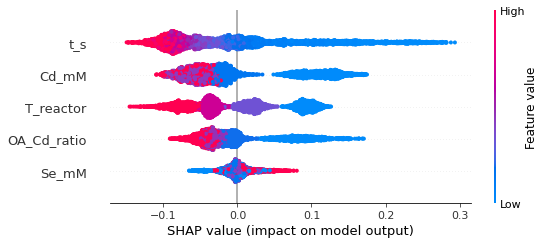

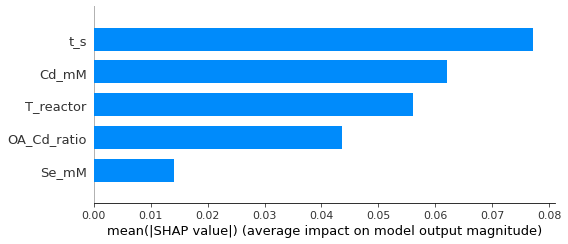

In [11]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

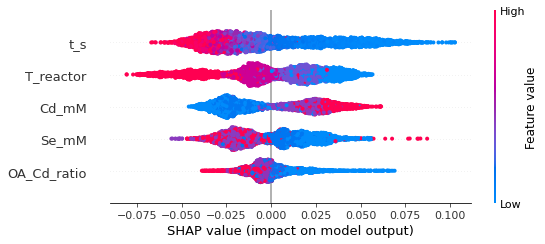

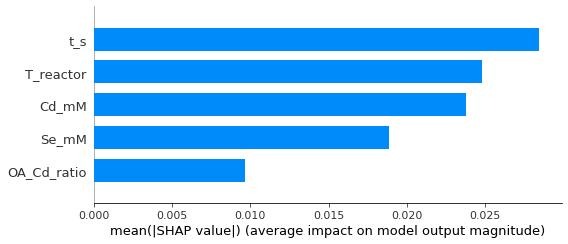

In [12]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

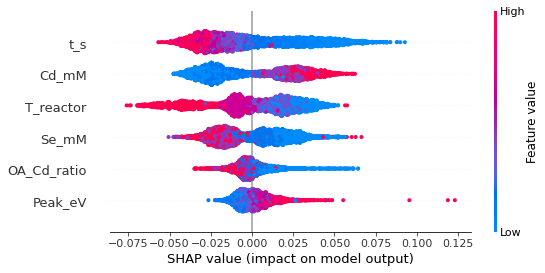

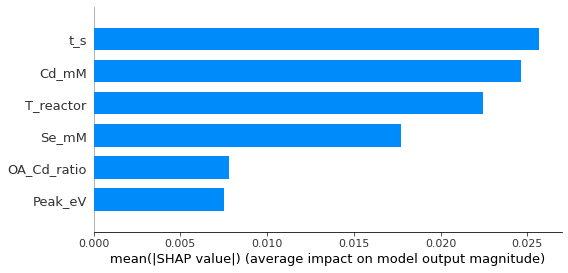

In [13]:
#SHAP on training data for Cascade
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")

In [14]:
#Train model on entire dataset (Emission)
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']
group = df['Expt. No']

#Random Forest models as optimized in Hyperparameter tuning
regressor_peak = RandomForestRegressor(max_depth= 17, 
                                       min_samples_split = 9, 
                                       min_samples_leaf = 1, 
                                       max_features = 2,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_fwhm = RandomForestRegressor(max_depth=15, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 4,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

regressor_cascade = RandomForestRegressor(max_depth=17, 
                                       min_samples_split = 2, 
                                       min_samples_leaf = 1, 
                                       max_features = 3,
                                       max_samples = 0.5,
                                       n_estimators = 100,
                                       random_state=0)

matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

#Separate out training and test sets (in this case they are the same)
X_train = X
X2_train = X2
y_train = y
z_train = z
X_test = X
y_test = y
z_test = z
j=0

#prediction for Peak
regressor_peak.fit(X_train, y_train)
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
regressor_fwhm.fit(X_train, z_train)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
regressor_cascade.fit(X2_train, z_train)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))

#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))
matrix[j,8:13] = regressor_peak.feature_importances_

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))
matrix_fwhm[j,8:13] = regressor_fwhm.feature_importances_

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))
matrix_cascade[j,8:14] = regressor_cascade.feature_importances_

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Training Accuracy' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("Importances\t", matrix[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("Importances\t", matrix_fwhm[0,8:13])
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("Importances\t", matrix_cascade[0,8:14])
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

Emission Peak/FWHM Training Accuracy
Emission Peak
MAE (eV):	 0.0832
R2 (eV):	 0.7017
RAE (eV):	 0.5353
RMSE (eV):	 0.1050
Importances	 [0.12564 0.17484 0.25141 0.08331 0.3648 ]
MAE (nm):	 19.0571
R2 (nm):	 0.6884
RAE (nm):	 0.5417
RMSE (nm):	 24.1659
Emission FWHM (direct)
MAE (eV):	 0.0053
R2 (eV):	 0.8825
RAE (eV):	 0.3119
RMSE (eV):	 0.0075
Importances	 [0.14784 0.18244 0.16352 0.1517  0.3545 ]
MAE (nm):	 2.7737
R2 (nm):	 0.7260
RAE (nm):	 0.5117
RMSE (nm):	 3.6334
Emission FWHM (cascade)
MAE (eV):	 0.0073
R2 (eV):	 0.7665
RAE (eV):	 0.4290
RMSE (eV):	 0.0106
Importances	 [0.1256  0.13755 0.12992 0.13003 0.27046 0.20645]
MAE (nm):	 3.0147
R2 (nm):	 0.6588
RAE (nm):	 0.5562
RMSE (nm):	 4.0544


In [15]:
#Test Linear model on interpolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (in).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Interpolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_in_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_in_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_in_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Interpolation
Emission Peak
MAE (eV):	 0.0520
R2 (eV):	 0.8043
RAE (eV):	 0.4324
RMSE (eV):	 0.0628
MAE (nm):	 11.6111
R2 (nm):	 0.8135
RAE (nm):	 0.4220
RMSE (nm):	 13.8466
Emission FWHM (direct)
MAE (eV):	 0.0110
R2 (eV):	 0.5085
RAE (eV):	 0.6432
RMSE (eV):	 0.0163
MAE (nm):	 2.7288
R2 (nm):	 0.5927
RAE (nm):	 0.5778
RMSE (nm):	 3.8761
Emission FWHM (cascade)
MAE (eV):	 0.0102
R2 (eV):	 0.5479
RAE (eV):	 0.5965
RMSE (eV):	 0.0157
MAE (nm):	 2.4938
R2 (nm):	 0.6377
RAE (nm):	 0.5281
RMSE (nm):	 3.6556


In [16]:
#Test Linear model on extrapolation, PL Peak, FWHM (eV)

#Test data set (interpolation)
df2 = pd.read_csv('CdSe PL Test (out).csv')
#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df2[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df2[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
y = df2['Peak_eV']
z = df2['FWHM_eV']

X_test = X
y_test = y
z_test = z

#prediction for Peak
y_pred = regressor_peak.predict(X_test)
#prediction for FWHM (direct)
y_pred_fwhm = regressor_fwhm.predict(X_test)
#prediction for FWHM (cascade)
X_test.insert(5, "Peak_eV", regressor_peak.predict(X_test), True)
y_pred_cascade = regressor_cascade.predict(X_test)


matrix = np.zeros([1,13])
matrix_fwhm = np.zeros([1,13])
matrix_cascade = np.zeros([1,14])

j=0

#errors in eV (normalized)
#UN-normalize eV predictions by scaling with ratio

ratio = (1239.84193/400 - 1239.84193/620)
ratio2 = 0.35
matrix[j,0] = metrics.mean_absolute_error(y_test, y_pred)*ratio
matrix[j,1] = metrics.r2_score(y_test, y_pred)
matrix[j,2] = rae(y_test, y_pred)
matrix[j,3] = ratio*np.sqrt(metrics.mean_squared_error(y_test, y_pred))

matrix_fwhm[j,0] = metrics.mean_absolute_error(z_test, y_pred_fwhm)*ratio2
matrix_fwhm[j,1] = metrics.r2_score(z_test, y_pred_fwhm)
matrix_fwhm[j,2] = rae(z_test, y_pred_fwhm)
matrix_fwhm[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_fwhm))

matrix_cascade[j,0] = metrics.mean_absolute_error(z_test, y_pred_cascade)*ratio2
matrix_cascade[j,1] = metrics.r2_score(z_test, y_pred_cascade)
matrix_cascade[j,2] = rae(z_test, y_pred_cascade)
matrix_cascade[j,3] = ratio2*np.sqrt(metrics.mean_squared_error(z_test, y_pred_cascade))


#errors in nm
#UNnormalize the data first
y_test = y_test*(1239.84193/400 - 1239.84193/620)+1239.84193/620
y_pred = y_pred*(1239.84193/400 - 1239.84193/620)+1239.84193/620
z_test = z_test*(0.35)+0.05
y_pred_fwhm = y_pred_fwhm*(0.35)+0.05
y_pred_cascade = y_pred_cascade*(0.35)+0.05

#Calculate data in nm and eV
matrix[j,4] = metrics.mean_absolute_error(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,5] = metrics.r2_score(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,6] = rae(peak_eV_nm(y_test), peak_eV_nm(y_pred))
matrix[j,7] = np.sqrt(metrics.mean_squared_error(peak_eV_nm(y_test), peak_eV_nm(y_pred)))

matrix_fwhm[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm))
matrix_fwhm[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_fwhm)))

matrix_cascade[j,4] = metrics.mean_absolute_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,5] = metrics.r2_score(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,6] = rae(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade))
matrix_cascade[j,7] = np.sqrt(metrics.mean_squared_error(FWHM_eV_nm(y_test,z_test), FWHM_eV_nm(y_pred,y_pred_cascade)))

np.set_printoptions(precision=5, threshold=5, edgeitems=4, suppress=True)

print('\033[1m' + 'Emission Peak/FWHM Extrapolation' + '\033[0m')
print('\033[1m' + 'Emission Peak' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix[0,7]))

print('\033[1m' + 'Emission FWHM (direct)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_fwhm[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_fwhm[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_fwhm[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_fwhm[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_fwhm[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_fwhm[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_fwhm[0,7]))

print('\033[1m' + 'Emission FWHM (cascade)' + '\033[0m')
print("MAE (eV):\t", "{:.4f}".format(matrix_cascade[0,0]))
print("R2 (eV):\t", "{:.4f}".format(matrix_cascade[0,1]))
print("RAE (eV):\t", "{:.4f}".format(matrix_cascade[0,2]))
print("RMSE (eV):\t", "{:.4f}".format(matrix_cascade[0,3]))
print("MAE (nm):\t","{:.4f}".format(matrix_cascade[0,4]))
print("R2 (nm):\t", "{:.4f}".format(matrix_cascade[0,5]))
print("RAE (nm):\t","{:.4f}".format(matrix_cascade[0,6]))
print("RMSE (nm):\t", "{:.4f}".format(matrix_cascade[0,7]))

y_test.to_numpy().reshape(1,-1)
z_test.to_numpy().reshape(1,-1)
y_pred.reshape(1,-1)
y_pred_fwhm.reshape(1,-1)
y_pred_cascade.reshape(1,-1)

np.savetxt("RF_PL_out_test_peak.csv", np.vstack((y_test,y_pred)).T, delimiter=",")
np.savetxt("RF_PL_out_test_fwhm.csv", np.vstack((z_test,y_pred_fwhm)).T, delimiter=",")
np.savetxt("RF_PL_out_test_cascade.csv", np.vstack((z_test,y_pred_cascade)).T, delimiter=",")

Emission Peak/FWHM Extrapolation
Emission Peak
MAE (eV):	 0.0422
R2 (eV):	 0.8601
RAE (eV):	 0.3407
RMSE (eV):	 0.0543
MAE (nm):	 9.6668
R2 (nm):	 0.8705
RAE (nm):	 0.3322
RMSE (nm):	 12.1873
Emission FWHM (direct)
MAE (eV):	 0.0099
R2 (eV):	 0.5635
RAE (eV):	 0.5659
RMSE (eV):	 0.0134
MAE (nm):	 2.5540
R2 (nm):	 0.3537
RAE (nm):	 0.6827
RMSE (nm):	 3.5936
Emission FWHM (cascade)
MAE (eV):	 0.0102
R2 (eV):	 0.5502
RAE (eV):	 0.5787
RMSE (eV):	 0.0136
MAE (nm):	 2.6112
R2 (nm):	 0.3358
RAE (nm):	 0.6980
RMSE (nm):	 3.6430


In [17]:
# load dataset into Pandas DataFrame (cleaned PL data)
df = pd.read_csv('CdSe PL Train Val.csv')

#normalize input and output data
min_params = pd.Series([0, 0, 3, 200, 0, 400, 15, 1239.84193/620, 0.05], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
max_params = pd.Series([50, 50, 150, 310, 600, 620, 80, 1239.84193/400, 0.4], index =['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV'])
df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] = (df[['Cd_mM', 'Se_mM', 'OA_Cd_ratio', 'T_reactor', 't_s','Peak_nm','FWHM_nm','Peak_eV','FWHM_eV']] - min_params) / (max_params- min_params)

X = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s']]
X2 = df[['OA_Cd_ratio','T_reactor','Cd_mM','Se_mM','t_s','Peak_eV']]
y = df['Peak_eV']
z = df['FWHM_eV']

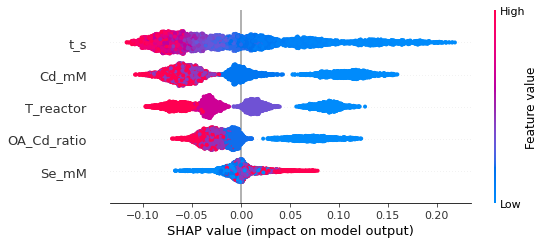

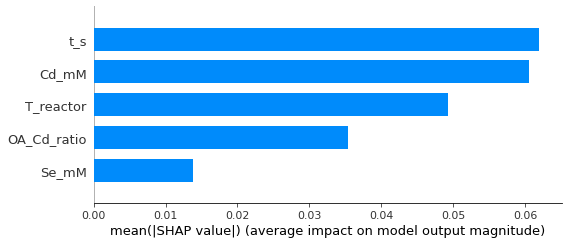

In [18]:
#SHAP on training data for Peak
import shap
tree_explainer = shap.TreeExplainer(regressor_peak)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

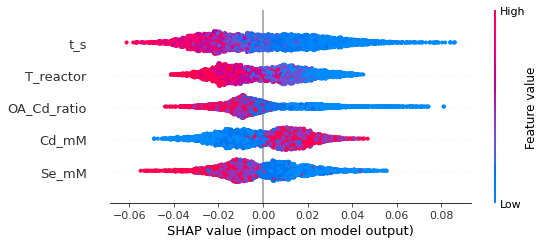

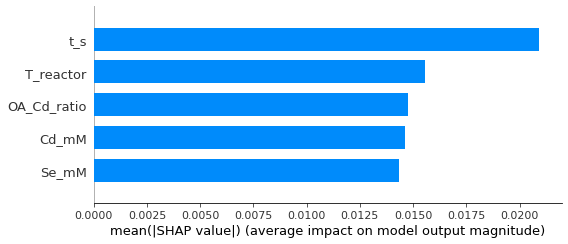

In [19]:
#SHAP on training data for FWHM
tree_explainer = shap.TreeExplainer(regressor_fwhm)
shap_values = tree_explainer.shap_values(X)
shap.summary_plot(shap_values, X)
shap.summary_plot(shap_values, X, plot_type="bar")

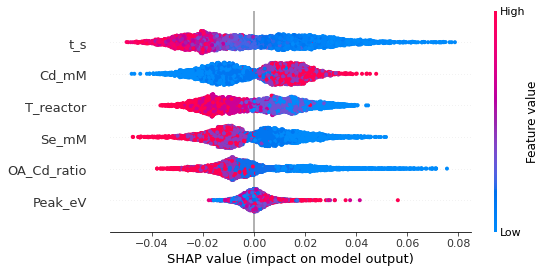

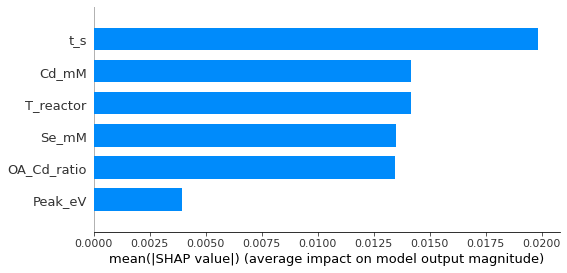

In [20]:
#SHAP on training data for FWHM (cascade)
tree_explainer = shap.TreeExplainer(regressor_cascade)
shap_values = tree_explainer.shap_values(X2)
shap.summary_plot(shap_values, X2)
shap.summary_plot(shap_values, X2, plot_type="bar")